## Create Plots to evaluate and visualize results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from scipy import interp
from sklearn.model_selection import KFold
from pylab import rcParams
import os
os.chdir('/home/roman/Documents/Projects/Cost_Sensitive')
import eval_results

In [2]:
# ---------- Prepare and load data ---------- #
data = pd.read_csv('data/creditcard.csv')
y = data.iloc[:, -1]
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=123, shuffle=True)
kf.get_n_splits(y)
train_index_l, test_index_l = [], []
y_train_l, y_test_l = [], []
for train_index, test_index in kf.split(y):
    train_index_l.append(train_index)
    test_index_l.append(test_index)
    y_train_l.append(y.iloc[train_index])
    y_test_l.append(y.iloc[test_index])

# load results and cost matrix:
y_pred_test_lr = np.load('results/y_pred_test_lr.npy')
y_pred_test_lr_probas = np.load('results/y_pred_test_lr_probas.npy')
y_pred_test_ann = np.load('results/y_pred_test_ann.npy')
y_pred_test_ann_probas = np.load('results/y_pred_test_ann_probas.npy')
y_pred_test_ann_cs = np.load('results/y_pred_test_ann_cs.npy')
y_pred_test_ann_cs_probas = np.load('results/y_pred_test_ann_cs_probas.npy')
y_pred_test_lr_mc = np.load('results/y_pred_test_lr_mc.npy')
y_pred_test_ann_mc = np.load('results/y_pred_test_ann_mc.npy')
cost_mat_test_l = np.load('results/cost_mat_test_l.npy')

### AUC-ROC

In [4]:
# ---------- Define functions ---------- #
# stack y_pred arrays to 2D (proba, 1-proba):
def stack_y_probas(y_proba):
    y_proba = np.hstack((y_proba, 1 - y_proba))
    return np.array([y_proba[:int(y_proba.shape[0]/2)], y_proba[int(y_proba.shape[0]/2):]]).T

def create_roc_auc(y_true, y_pred):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc

# Create mean roc_auc for list of CV results:
def create_mean_roc_auc(y_true_l, y_pred_l):
    fpr_l, tpr_l, roc_auc_l, tprs_l = [], [], [], []
    mean_fpr = np.linspace(0, 1, 100)
    for y_true, y_pred in zip(y_true_l, y_pred_l):
        fpr, tpr, roc_auc = create_roc_auc(y_true, y_pred)
        tprs_l.append(interp(mean_fpr, fpr[1], tpr[1]))
        tprs_l[-1][0] = 0.0
        roc_auc_l.append(roc_auc)
    mean_tpr = np.mean(tprs_l, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    return mean_fpr, mean_tpr, mean_auc

In [5]:
# transform data to right format
y_test_2D = []
for y_test in y_test_l:
    y_test = LabelBinarizer().fit_transform(y_test)
    y_test = np.hstack((y_test, 1 - y_test))
    y_test_2D.append(y_test)
y_pred_test_lr_probas_2D, y_pred_test_ann_probas_2D, y_pred_test_ann_cs_probas_2D = [], [], []
for i in range(n_splits):
    y_pred_test_lr_probas_2D.append(stack_y_probas(y_pred_test_lr_probas[i]))
    y_pred_test_ann_probas_2D.append(stack_y_probas(y_pred_test_ann_probas[i]))
    y_pred_test_ann_cs_probas_2D.append(stack_y_probas(y_pred_test_ann_cs_probas[i].reshape(-1)))

# calculate mean curves:
mean_fpr_lr, mean_tpr_lr, mean_auc_lr = create_mean_roc_auc(y_test_2D, y_pred_test_lr_probas_2D)
mean_fpr_ann, mean_tpr_ann, mean_auc_ann = create_mean_roc_auc(y_test_2D, y_pred_test_ann_probas_2D)
mean_fpr_ann_cs, mean_tpr_ann_cs, mean_auc_ann_cs = \
    create_mean_roc_auc(y_test_2D, y_pred_test_ann_cs_probas_2D)

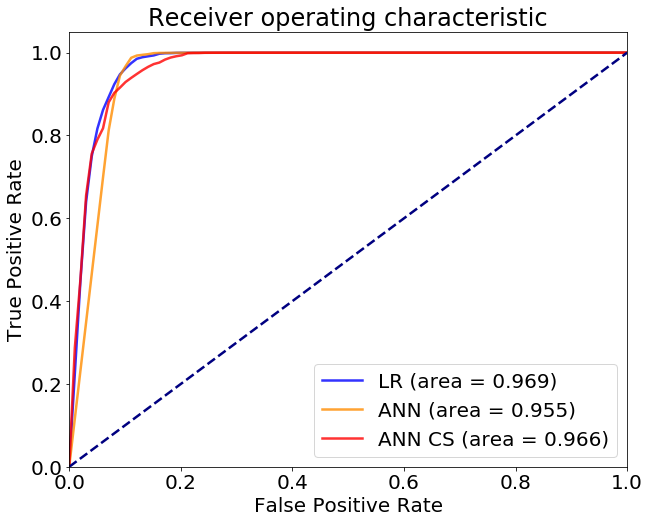

In [6]:
# Plot ROC curve
lw = 2.5
alpha = 0.8
plt.rcParams.update({'font.size': 20, 'figure.figsize': [10,8]})
#plt.style.use('seaborn-darkgrid')
plt.plot(mean_fpr_lr, mean_tpr_lr, color='blue', lw=lw, alpha=alpha, \
         label='LR (area = %0.3f)' % mean_auc_lr)
plt.plot(mean_fpr_ann, mean_tpr_ann, color='darkorange', lw=lw, alpha=alpha, \
         label='ANN (area = %0.3f)' % mean_auc_ann)
plt.plot(mean_fpr_ann_cs, mean_tpr_ann_cs, color='red', lw=lw, alpha=alpha, \
         label='ANN CS (area = %0.3f)' % mean_auc_ann_cs)
        
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Scatter plots of prediction results

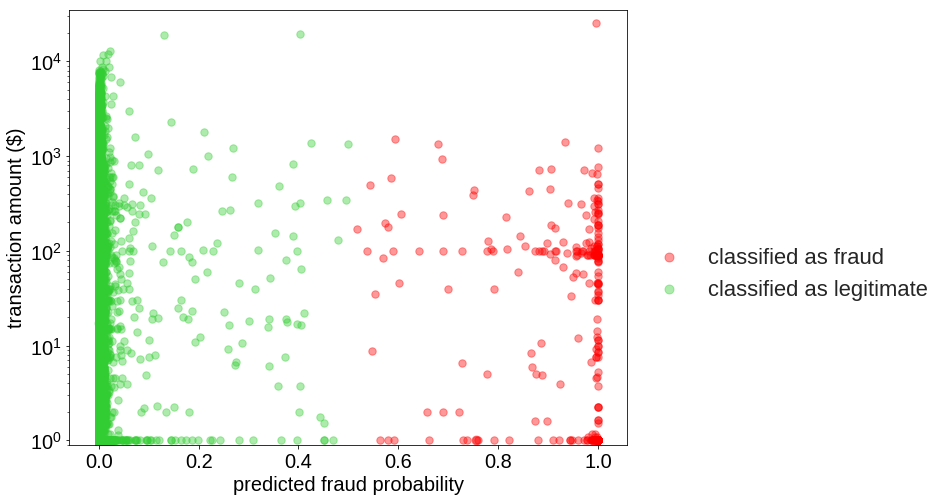

In [7]:
# Logistic regression regular:
fig, ax = plt.subplots()
ax.set_yscale('log')
plt.rcParams.update({'figure.figsize': [9, 8], 'font.size': 22})
plt.style.use('seaborn-whitegrid')
for i in range(len(y_pred_test_lr_mc)):
    mc_neg = y_pred_test_lr[i] == 0
    mc_pos = y_pred_test_lr[i] == 1
    amount_neg = list(data['Amount'][test_index_l[i]][mc_neg])
    amount_pos = list(data['Amount'][test_index_l[i]][mc_pos])
    ax.scatter(y_pred_test_lr_probas[i][mc_neg], amount_neg, alpha=0.4, s=55, color='limegreen')
    ax.scatter(y_pred_test_lr_probas[i][mc_pos], amount_pos, alpha=0.4, s=55, color='red')
ax.scatter(y_pred_test_lr_probas[i][mc_pos][0], amount_pos[0], alpha=0.4, s=80, color='red',\
           label='classified as fraud')
ax.scatter(y_pred_test_lr_probas[i][mc_neg][0], amount_neg[0], alpha=0.4, s=80, color='limegreen', \
           label='classified as legitimate')
ax.legend(bbox_to_anchor=(1, 0.5))
ax.set_ylim([9 * 1e-1, 3.5 * 1e4])
ax.set_xlabel('predicted fraud probability')
ax.set_ylabel('transaction amount ($)')
plt.show()

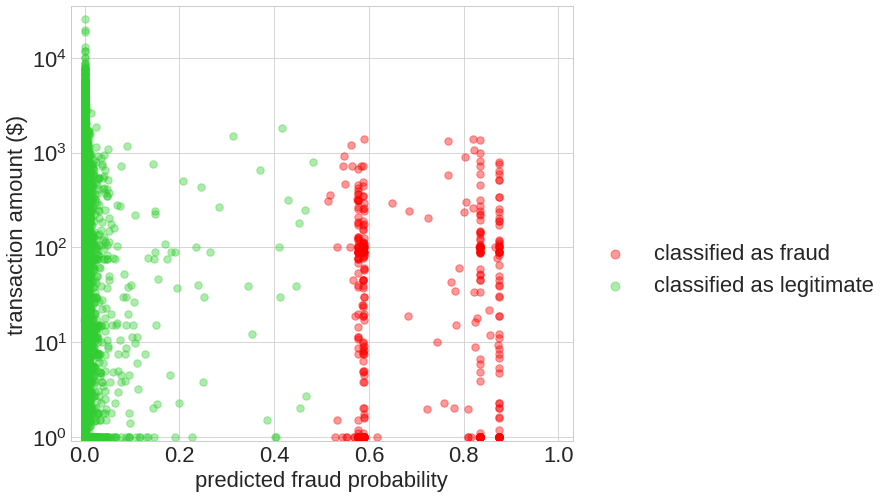

In [8]:
# ANN regular:
fig, ax = plt.subplots()
ax.set_yscale('log')
plt.rcParams.update({'figure.figsize': [9, 8], 'font.size': 22})
plt.style.use('seaborn-whitegrid')
for i in range(len(y_pred_test_ann)):
    mc_neg = y_pred_test_ann[i] == 0
    mc_pos = y_pred_test_ann[i] == 1
    amount_neg = list(data['Amount'][test_index_l[i]][mc_neg])
    amount_pos = list(data['Amount'][test_index_l[i]][mc_pos])
    ax.scatter(y_pred_test_ann_probas[i][mc_neg], amount_neg, alpha=0.4, s=55, color='limegreen')
    ax.scatter(y_pred_test_ann_probas[i][mc_pos], amount_pos, alpha=0.4, s=55, color='red')
ax.scatter(y_pred_test_ann_probas[i][mc_pos][0], amount_pos[0], alpha=0.4, s=80, color='red',\
           label='classified as fraud')
ax.scatter(y_pred_test_ann_probas[i][mc_neg][0], amount_neg[0], alpha=0.4, s=80, color='limegreen', \
           label='classified as legitimate')
ax.legend(bbox_to_anchor=(1, 0.5))
ax.set_xlim([-0.03, 1.03])
ax.set_ylim([9 * 1e-1, 3.5 * 1e4])
ax.set_xlabel('predicted fraud probability')
ax.set_ylabel('transaction amount ($)')
plt.show()

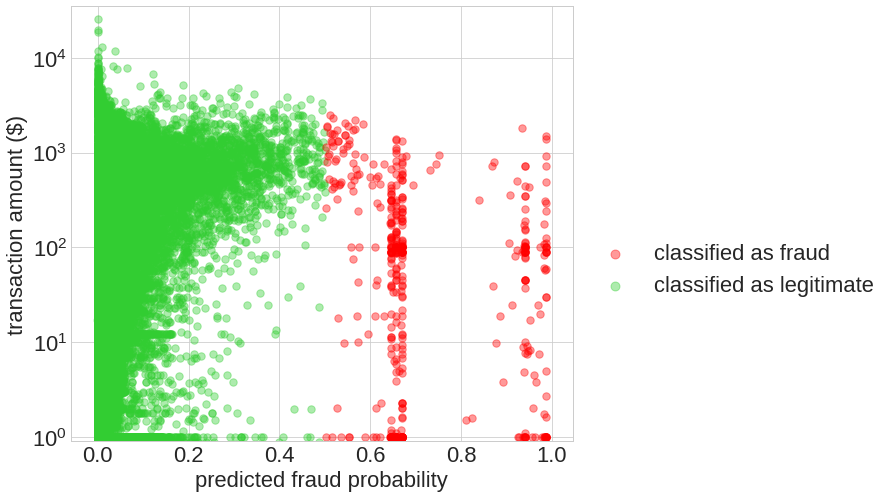

In [9]:
# ANN Cost-Sensitive:
fig, ax = plt.subplots()
ax.set_yscale('log')
plt.rcParams.update({'figure.figsize': [9, 8], 'font.size': 22})
plt.style.use('seaborn-whitegrid')
for i in range(len(y_pred_test_ann_cs)):
    mc_neg = y_pred_test_ann_cs[i] == 0
    mc_pos = y_pred_test_ann_cs[i] == 1
    amount_neg = list(data['Amount'][test_index_l[i]][mc_neg])
    amount_pos = list(data['Amount'][test_index_l[i]][mc_pos])
    ax.scatter(y_pred_test_ann_cs_probas[i][mc_neg], amount_neg, alpha=0.4, s=55, color='limegreen')
    ax.scatter(y_pred_test_ann_cs_probas[i][mc_pos], amount_pos, alpha=0.4, s=55, color='red')
ax.scatter(y_pred_test_ann_cs_probas[i][mc_pos][0], amount_pos[0], alpha=0.4, s=80, color='red',\
           label='classified as fraud')
ax.scatter(y_pred_test_ann_cs_probas[i][mc_neg][0], amount_neg[0], alpha=0.4, s=80, color='limegreen', \
           label='classified as legitimate')
ax.legend(bbox_to_anchor=(1, 0.5))
ax.set_ylim([9 * 1e-1, 3.5 * 1e4])
ax.set_xlabel('predicted fraud probability')
ax.set_ylabel('transaction amount ($)')
plt.show()

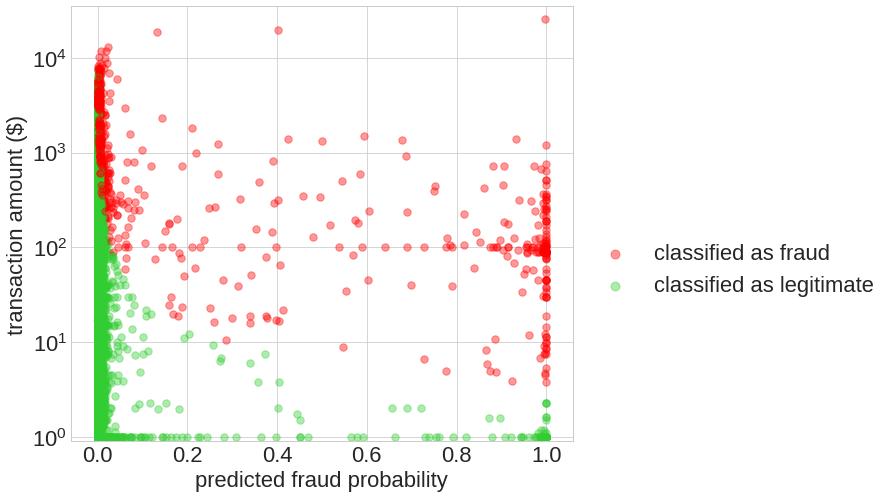

In [10]:
# Logistic regression cost classification:
fig, ax = plt.subplots()
#ax.set_yscale('symlog')
ax.set_yscale('log')
plt.rcParams.update({'figure.figsize': [9, 8], 'font.size': 22})
plt.style.use('seaborn-whitegrid')
#mc_neg, mc_pos = [], []
for i in range(len(y_pred_test_lr_mc)):
    mc_neg = y_pred_test_lr_mc[i] == 0
    mc_pos = y_pred_test_lr_mc[i] == 1
    amount_neg = list(data['Amount'][test_index_l[i]][mc_neg])
    amount_pos = list(data['Amount'][test_index_l[i]][mc_pos])
    ax.scatter(y_pred_test_lr_probas[i][mc_neg], amount_neg, alpha=0.4, s=55, color='limegreen')
    ax.scatter(y_pred_test_lr_probas[i][mc_pos], amount_pos, alpha=0.4, s=55, color='red')
ax.scatter(y_pred_test_lr_probas[i][mc_pos][0], amount_pos[0], alpha=0.4, s=80, color='red',\
           label='classified as fraud')
ax.scatter(y_pred_test_lr_probas[i][mc_neg][0], amount_neg[0], alpha=0.4, s=80, color='limegreen', \
           label='classified as legitimate')
ax.legend(bbox_to_anchor=(1, 0.5))
ax.set_ylim([9 * 1e-1, 3.5 * 1e4])
ax.set_xlabel('predicted fraud probability')
ax.set_ylabel('transaction amount ($)')
plt.show()

In [ ]:
#y_pred_test_lr_mc[0].shape
#amount.shape
#y_pred_test_lr_probas[0].shape[0]
#list(amount)[1]
y_pred_test_lr_mc[0]
y_pred_test_lr_probas[0].shape[0]
#list(y_test_l[0])[1]

y_pred_test_lr_probas[0][mc_pos].shape
data['Amount'][test_index_l[0]]

### Barplots to evaluate test results

In [11]:
f1_lr, cs_lr = eval_results.scores_and_costs(y_test_l, y_pred_test_lr, cost_mat_test_l)
f1_ann, cs_ann = eval_results.scores_and_costs(y_test_l, y_pred_test_ann, cost_mat_test_l)
f1_ann_cs, cs_ann_cs = eval_results.scores_and_costs(y_test_l, y_pred_test_ann_cs, cost_mat_test_l)
f1_lr_mc, cs_lr_mc = eval_results.scores_and_costs(y_test_l, y_pred_test_lr_mc, cost_mat_test_l)
f1_ann_mc, cs_ann_mc = eval_results.scores_and_costs(y_test_l, y_pred_test_ann_mc, cost_mat_test_l)
df_results = pd.DataFrame(np.array([[np.mean(cs_lr), np.mean(f1_lr)], [np.mean(cs_ann), np.mean(f1_ann)], \
                      [np.mean(cs_ann_cs), np.mean(f1_ann_cs)], [np.mean(cs_lr_mc), np.mean(f1_lr_mc)], \
                      [np.mean(cs_ann_mc), np.mean(f1_ann_mc)]]))

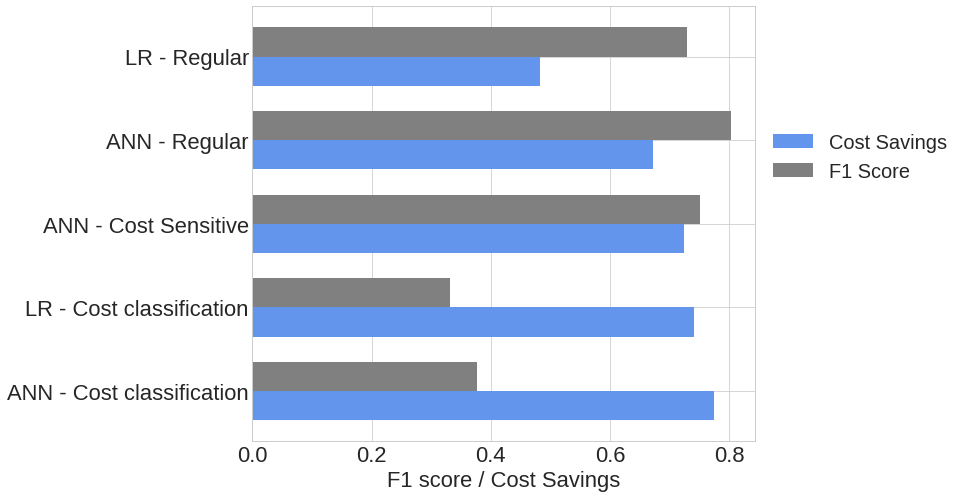

In [13]:
# All results: cost savings and F1-score
df_results.index = ['LR - Regular','ANN - Regular','ANN - Cost Sensitive', \
                    'LR - Cost classification','ANN - Cost classification']
df_results.columns = ['Cost Savings', 'F1 Score']

fig, ax = plt.subplots()
plt.rcParams.update({'figure.figsize': [8, 5], 'font.size': 22})
plt.rcParams.update({'font.size': 20, 'figure.figsize': [10,8]})
ax = df_results[::-1].plot.barh(ax=ax, color=['cornflowerblue', 'gray'], width=0.7)
ax.legend(bbox_to_anchor=(1, 0.75))
ax.set_xlabel('F1 score / Cost Savings')
plt.show()

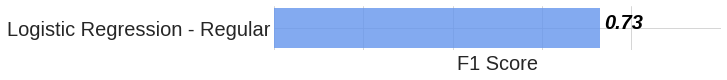

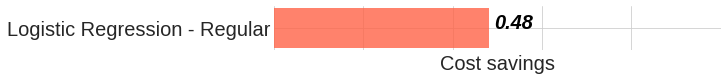

In [15]:
# LR regular only
fontsize = 20
df_1_f1 = df_results.iloc[0, 1]
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 20, 'figure.figsize': [8, 0.8]})
ax.barh('Logistic Regression - Regular', df_1_f1, color='cornflowerblue', alpha=0.8)
ax.set_xlim([0, 1])
plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)
ax.set_xlabel('F1 Score')
label = np.round(df_1_f1, 2)
rect = ax.patches[0]
x_value = rect.get_width()
y_value = rect.get_y() + rect.get_height() / 2
ax.text(x_value + 0.01, y_value, label, color='black', fontsize=fontsize, style='italic', weight='bold')#,
plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(top=False, bottom=False, right=False, axis='both', which='both', length=0)
plt.box(False)
plt.show()

df_1_cs = df_results.iloc[0, 0]
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 20, 'figure.figsize': [8, 0.8]})
ax.barh('Logistic Regression - Regular', df_1_cs, color='tomato', alpha=0.8)
ax.set_xlim([0, 1])
plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)
ax.set_xlabel('Cost savings')
label = np.round(df_1_cs, 2)
rect = ax.patches[0]
x_value = rect.get_width()
y_value = rect.get_y() + rect.get_height() / 2
ax.text(x_value + 0.01, y_value, label, color='black', fontsize=fontsize, style='italic', weight='bold')#,
plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(top=False, bottom=False, right=False, axis='both', which='both', length=0)
plt.box(False)
plt.show()

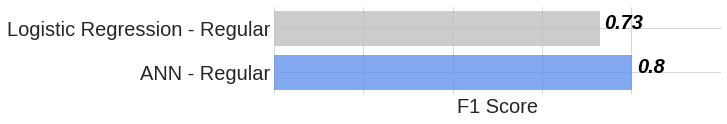

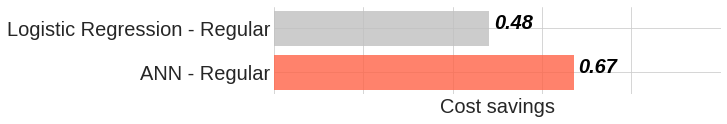

In [17]:
# LR regular + ANN regular:
df_2_f1 = df_results.iloc[0:2, 1]
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': fontsize, 'figure.figsize': [8, 1.6]})
ax.barh(['ANN - Regular', 'Logistic Regression - Regular'], df_2_f1[::-1], \
        color=['cornflowerblue', 'silver'], alpha=0.8)
ax.set_xlim([0, 1])
ax.set_xlabel('F1 Score')
labels = list(df_2_f1[:].apply(lambda x: np.round(x, 2)))[::-1]
rects = ax.patches
for rect, label in zip(rects, labels):
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    ax.text(x_value + 0.01, y_value, label, color='black', fontsize=fontsize, style='italic', weight='bold')#,
plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(top=False, bottom=False, right=False, axis='both', which='both', length=0)
plt.box(False)
plt.show()

df_2_cs = df_results.iloc[0:2, 0]
fig, ax = plt.subplots()
ax.barh(['ANN - Regular', 'Logistic Regression - Regular'], df_2_cs[::-1], \
        color=['tomato', 'silver'], alpha=0.8)
ax.set_xlim([0, 1])
ax.set_xlabel('Cost savings')
labels = list(df_2_cs[:].apply(lambda x: np.round(x, 2)))[::-1]
rects = ax.patches
for rect, label in zip(rects, labels):
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    ax.text(x_value + 0.01, y_value, label, color='black', fontsize=fontsize, style='italic', weight='bold')#,
plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(top=False, bottom=False, right=False, axis='both', which='both', length=0)
plt.box(False)
plt.show()

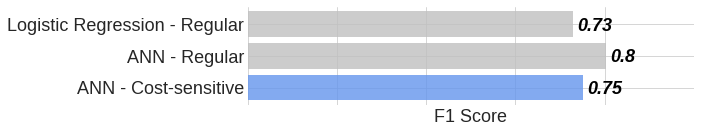

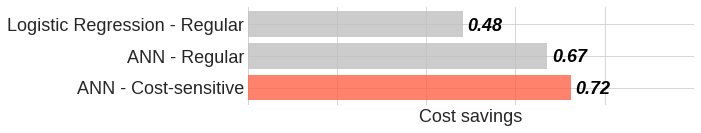

In [19]:
# LR regular + ANN regular + ANN cost sensitive
fontsize = 18
df_3_f1 = df_results.iloc[0:3, 1]
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': fontsize, 'figure.figsize': [8, 1.8]})
ax.barh(['ANN - Cost-sensitive', 'ANN - Regular', 'Logistic Regression - Regular'], df_3_f1[::-1], \
        color=['cornflowerblue', 'silver', 'silver'], alpha=0.8)
ax.set_xlim([0, 1])
ax.set_xlabel('F1 Score')
labels = list(df_3_f1[:].apply(lambda x: np.round(x, 2)))[::-1]
rects = ax.patches
for rect, label in zip(rects, labels):
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    ax.text(x_value + 0.01, y_value - 0.2, label, color='black', fontsize=fontsize, style='italic', weight='bold')#,
plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(top=False, bottom=False, right=False, axis='both', which='both', length=0)
plt.box(False)
plt.show()

df_3_cs = df_results.iloc[0:3, 0]
fig, ax = plt.subplots()
ax.barh(['ANN - Cost-sensitive', 'ANN - Regular', 'Logistic Regression - Regular'], df_3_cs[::-1], \
        color=['tomato', 'silver', 'silver'], alpha=0.8)
ax.set_xlim([0, 1])
ax.set_xlabel('Cost savings')
labels = list(df_3_cs[:].apply(lambda x: np.round(x, 2)))[::-1]
rects = ax.patches
for rect, label in zip(rects, labels):
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    ax.text(x_value + 0.01, y_value - 0.2, label, color='black', fontsize=fontsize, style='italic', weight='bold')#,
plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(top=False, bottom=False, right=False, axis='both', which='both', length=0)
plt.box(False)
plt.show()

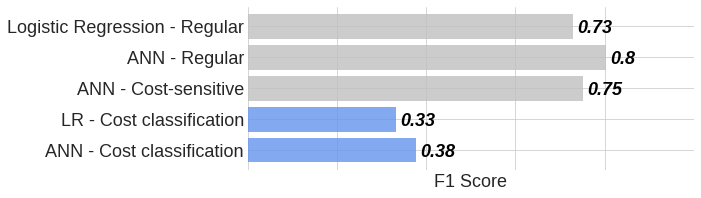

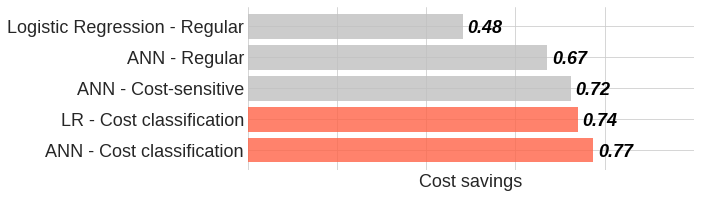

In [21]:
# LR regular + ANN regular + ANN cost sensitive + LR cost classification + ANN cost classification
fontsize = 18
df_5_f1 = df_results.iloc[:, 1]
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': fontsize, 'figure.figsize': [8, 3]})
ax.barh(['ANN - Cost classification', 'LR - Cost classification', 'ANN - Cost-sensitive',\
         'ANN - Regular', 'Logistic Regression - Regular'], df_5_f1[::-1], \
        color=['cornflowerblue', 'cornflowerblue', 'silver', 'silver', 'silver'], alpha=0.8)
ax.set_xlim([0, 1])
ax.set_xlabel('F1 Score')
labels = list(df_5_f1[:].apply(lambda x: np.round(x, 2)))[::-1]
rects = ax.patches
for rect, label in zip(rects, labels):
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    ax.text(x_value + 0.01, y_value - 0.2, label, color='black', fontsize=fontsize, style='italic', weight='bold')#,
plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(top=False, bottom=False, right=False, axis='both', which='both', length=0)
plt.box(False)
plt.show()

df_5_cs = df_results.iloc[:, 0]
fig, ax = plt.subplots()
ax.barh(['ANN - Cost classification', 'LR - Cost classification', 'ANN - Cost-sensitive', \
         'ANN - Regular', 'Logistic Regression - Regular'], df_5_cs[::-1], \
        color=['tomato', 'tomato', 'silver', 'silver', 'silver'], alpha=0.8)
ax.set_xlim([0, 1])
ax.set_xlabel('Cost savings')
labels = list(df_5_cs[:].apply(lambda x: np.round(x, 2)))[::-1]
rects = ax.patches
for rect, label in zip(rects, labels):
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    ax.text(x_value + 0.01, y_value - 0.2, label, color='black', fontsize=fontsize, style='italic', weight='bold')#,
plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(top=False, bottom=False, right=False, axis='both', which='both', length=0)
plt.box(False)
plt.show()